# LAB 2
## kNN class

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import average
from pandas import unique
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error

class kNN:
    def __init__(self, k=3, exp=2):
        # constructor for kNN classifier
        # k is the number of neighbor for local class estimation
        # exp is the exponent for the Minkowski distance
        self.s = 1e-6
        self.k = k
        self.exp = exp

    def fit(self, xtr, ytr):
        # training k-NN method X_train is the training data given
        # with input attributes. n-th row correponds to n-th
        # instance. Y_train is the output data (output vector):
        # n-th element of Y_train is the output value for n-th
        # instance in X_train.
        self.X_train = xtr
        self.Y_train = ytr

    def get_discrete_classification(self, X_test):
        # predict-class k-NN method
        # X_test is the test data given with input attributes. Rows correspond to instances
        # Method outputs prediction vector Y_pred_test:
        # n-th element of Y_pred_test is the prediction
        # for n-th instance in X_test

        Y_pred_test = []  # prediction vector Y_pred_test for all the test instances
        # in X_test is initialized to empty list []

        for i in range(len(X_test)):  # iterate over all instances in X_test
            test_instance = X_test.iloc[i]  # i-th test instance

            distances = []  # list of distances of the i-th test_instance for all the
            # train_instance s in X_train, initially empty.

            for j in range(len(self.X_train)):  # iterate over all instances in X_train
                train_instance = self.X_train.iloc[j]  # j-th training instance
                distance = self.minkowski_distance(test_instance,
                                                   train_instance)
                # distance between i-th test instance and j-th
                # training instance
                distances.append(distance)
                # add the distance to the list of distances of the i-th test_instance

            # Store distances in a dataframe. The dataframe has the index of Y_train in order to keep the
            # correspondence with the classes of the training instances
            df_dists = pd.DataFrame(data=distances, columns=['dist'], index=self.Y_train.index)

            # Sort distances, and only consider the k closest points in the new dataframe df_knn
            df_nn = df_dists.sort_values(by=['dist'], axis=0)
            df_knn = df_nn[:self.k]

            # Note that the index df_knn.index of df_knn contains
            # indices in Y_train of the k-closed training
            # instances to the i-th test instance.
            # Thus, the dataframe self.Y_train[df_knn.index] contains the
            # classes of those k-closed training instances.
            # Method value_counts() computes the counts (number of
            # occurrences) for each class in self.Y_train[df_knn.index]
            # in dataframe predictions.
            predictions = self.Y_train[df_knn.index].value_counts()

            # the first element of the index predictions.index contains
            # the class with the highest count; i.e. the
            # prediction y_pred_test.
            y_pred_test = predictions.index[0]
            # add the prediction y_pred_test to the prediction
            # vector Y_pred_test for all the test instances in X_test
            Y_pred_test.append(y_pred_test)

        return Y_pred_test

    def minkowski_distance(self, x1, x2):
        # computes the Minkowski distance of x1 and x2
        # for two labeled instances (x1,y1) and (x2,y2)
        # Set initial distance to 0
        distance = 0
        # Calculate Minkowski distance using the exponent exp
        for i in range(len(x1)):
            distance = distance + abs(x1[i] - x2[i]) ** self.exp
        distance = distance ** (1 / self.exp)
        return distance

    def get_class_probs(self, X_test,Y_test ,s = None):
        if s is not None:
            self.s = s
        # function to evaluate posterior classes probabilities
        classes = unique(Y_test)  # set of unique classes
        # create dataframe with columns = prob(class_i) and index = test_instances.index
        probs = pd.DataFrame(data=np.zeros((len(X_test.index), len(classes))),
                             columns=classes,
                             index=X_test.index)

        for i in range(len(X_test)):  # for each test instance
            predictions = self.predict(X_test, i)
            # calculate probability for each class
            for x in predictions.index:
                instance = probs.iloc[i]
                instance.loc[x] = self.get_class_probability(predictions[x], len(classes))

        # return join of the two tables
        return pd.concat([X_test, probs], axis=1)



    def get_prediction(self, X_test):
        # function to evaluate regression value for the output attribute
        vals = pd.DataFrame(data=np.zeros((len(X_test.index), 1)),
                            columns=['regression value'],
                            index=X_test.index)
        for i in range(len(X_test)):
            predictions = self.predict(X_test, i)
            vals.iloc[i] = average(predictions.index)
            # allocate at index of the test instance the average value of the k predictions
        return pd.concat([X_test, vals], axis=1)
    def get_class_probability(self, n_instances_class_i, n_classes):
        # function to evaluate the probability for an instance to belong to a certain class
        # given #(instances of class i) and total #classes
        return (n_instances_class_i + self.s) / (self.k + n_classes * self.s)

    def predict(self, X_test, i):
        # function to evaluate prediction values for the output attribute
        distances = []
        for j in range(len(self.X_train)):  # find neighbours
            distance = self.minkowski_distance(X_test.iloc[i], self.X_train.iloc[j])
            distances.append(distance)

        df_dists = pd.DataFrame(data=distances, columns=['dist'], index=self.Y_train.index)
        df_knn = df_dists.sort_values(by=['dist'], axis=0)[:self.k]
        return self.Y_train[df_knn.index].value_counts()  # select and return the k-nearest

## Normalization function

In [16]:
def normalize(df):
    return (df - df.min()) / (df.max() - df.min())

## Data reading function

In [17]:
def read_data(file_name):
    data = pd.read_csv(file_name)
    y = data['class']
    x = data.drop(['class'], axis=1)
    data.head()
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.34, random_state=10)
    return x_train, x_test, y_train, y_test


## Task B

Test  the kNN classifier  on  the diabetes and glass classification  data  sets for the case when the data
is not normalized and the case when the data is normalized in function of parameter k of the kNN classifier.

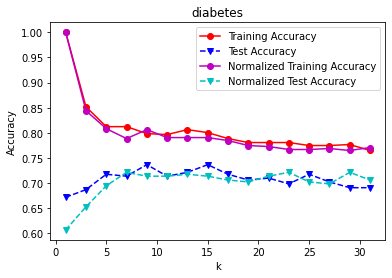

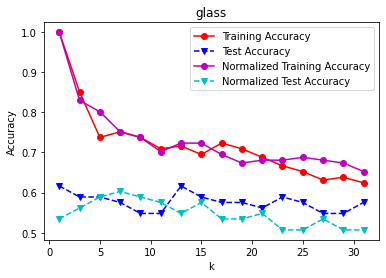

In [18]:

##################################################
# Hold-out testing: Variation on k parameter
##################################################
def hold_out_k_range(xtr, xt, ytr, yt, k_r, title):
    tr_acc = np.zeros(len(k_r))
    t_acc = np.zeros(len(k_r))
    tr_acc_n = np.zeros(len(k_r))
    t_acc_n = np.zeros(len(k_r))
    n_xtr = normalize(xtr)
    n_xt = normalize(xt)
    i = 0
    for k in k_r:
        clf = kNN(k)
        clf.fit(xtr, ytr)
        tr_acc[i] = accuracy_score(ytr, clf.get_discrete_classification(xtr))
        t_acc[i] = accuracy_score(yt, clf.get_discrete_classification(xt))
        clf.fit(n_xtr, ytr)
        tr_acc_n[i] = accuracy_score(ytr, clf.get_discrete_classification(n_xtr))
        t_acc_n[i] = accuracy_score(yt, clf.get_discrete_classification(n_xt))
        i += 1

    plt.plot(k_r, tr_acc, 'ro-',
             k_r, t_acc, 'bv--',
             k_r, tr_acc_n, 'mo-',
             k_r, t_acc_n, 'cv--')
    plt.legend(['Training Accuracy', 'Test Accuracy',
                'Normalized Training Accuracy', 'Normalized Test Accuracy'])
    plt.xlabel('k')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.show()
    return


k_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]
exp_range = [2, 100, 1000, 10000]

diabetes = 'data/diabetes.csv'
glass = 'data/glass.csv'
X_Train, X_Test, Y_Train, Y_Test = read_data(diabetes)
hold_out_k_range(X_Train, X_Test, Y_Train, Y_Test, k_range, 'diabetes')

X_Train, X_Test, Y_Train, Y_Test = read_data(glass)
hold_out_k_range(X_Train, X_Test, Y_Train, Y_Test, k_range, 'glass')

**_Indicate whether the training and hold-out accuracy rates improve with normalization._**

The normalization of the dataset seemed to improve the accuracy in both training and
testing hold-out validation, for both glass and diabetes datasets.
Mainly the testing accuracy seems loosing more accuracy when normalized, since the training did not 
lose too much accuracy with normalization.
Normalization performs better on the diabetes dataset
Especially when k is around (5,15), there is a small region of optimality


Test the kNN classifier on the glass classification data sets the data is normalized for different values  of
the exp parameter of  the  Minkowski  distance.

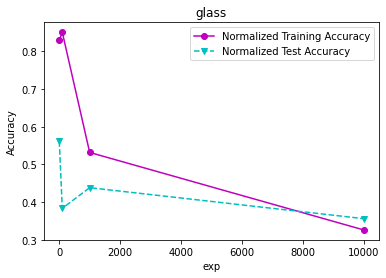

In [19]:
##################################################
# Hold-out testing: Variation on exp parameter
##################################################
def hold_out_exp_range(xtr, xt, ytr, yt, exp_r, title):
    tr_acc_n = np.zeros(len(exp_r))
    t_acc_n = np.zeros(len(exp_r))
    n_xtr = normalize(xtr)
    n_xt = normalize(xt)
    i = 0
    for exp in exp_r:
        clf = kNN(k=3, exp= exp)
        clf.fit(n_xtr, ytr)
        tr_acc_n[i] = accuracy_score(ytr, clf.get_discrete_classification(n_xtr))
        t_acc_n[i] = accuracy_score(yt, clf.get_discrete_classification(n_xt))
        i += 1

    plt.plot(exp_r, tr_acc_n, 'mo-',
             exp_r, t_acc_n, 'cv--')
    plt.legend(['Normalized Training Accuracy', 'Normalized Test Accuracy'])
    plt.xlabel('exp')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.show()
    return

X_Train, X_Test, Y_Train, Y_Test = read_data(glass)
hold_out_exp_range(X_Train, X_Test, Y_Train, Y_Test, exp_range, 'glass')

**_Indicate  whether the training and hold-out accuracy rates changes due to exp._**

Both training and testing accuracy highly decrease when the exp parameter is above 10
Therefore we can conclude the classification is more performant with a low exp parameter
Especially when exp is around 1000, there is a small region of optimality


## Task C
Add to class kNN method getClassProbs that computes for all the test instances in X_test the posterior
class probabilities. This means that the method computes for each row(instance) in X_test a row with
probability of class 1, probability of class 2, and probability of class N.
Combine the rows of the posterior class probabilities in the pandas.DataFrame object that
will be the output of the method getClassProbs.


**__*see get_class_probs(self, X_test) in kNN class__**

In [20]:
X_Train, X_Test, Y_Train, Y_Test = read_data(diabetes)
c = kNN(3, 2)
c.fit(X_Train, Y_Train)
print(c.get_class_probs(X_Test, Y_Test, s=1e-9).head(n= 5))


X_Train, X_Test, Y_Train, Y_Test = read_data(glass)
c = kNN(3, 2)
c.fit(X_Train, Y_Train)
print(c.get_class_probs(X_Test, Y_Test, s=1e-9).head(n= 5))

     preg  plas  pres  skin  insu  mass   pedi  age  tested_negative  \
568     4   154    72    29   126  31.3  0.338   37         0.000000   
620     2   112    86    42   160  38.4  0.246   28         0.666667   
456     1   135    54     0     0  26.7  0.687   62         0.333333   
197     3   107    62    13    48  22.9  0.678   23         1.000000   
714     3   102    74     0     0  29.5  0.121   32         0.333333   

     tested_positive  
568         1.000000  
620         0.333333  
456         0.666667  
197         0.000000  
714         0.666667  
          RI     Na    Mg    Al     Si     K    Ca   Ba    Fe  \
161  1.52172  13.51  3.86  0.88  71.79  0.23  9.54  0.0  0.11   
120  1.51660  12.99  3.18  1.23  72.97  0.58  8.81  0.0  0.24   
105  1.51316  13.02  0.00  3.04  70.48  6.21  6.96  0.0  0.00   
148  1.51574  14.86  3.67  1.74  71.87  0.16  7.36  0.0  0.12   
69   1.52152  13.05  3.65  0.87  72.32  0.19  9.85  0.0  0.17   

     'build wind float'  'build wind n

## Task D
Add to class kNN method getPrediction that computes for all the test instances in X_test regression values for
the output attribute. This means that the method computes for each instance(row) in X_test a regression value equal
to the average of y values in Y_train of the k-nearest neighbors of the instance in X_train.
Combine the computed regression values for all the instances in X_test in pandas.DataFrame object that will
be the output of the method getPrediction.


**__*see get_prediction(self, X_test) function in kNN class__**

Test the method getPrediction on the autoprice data set which is a regression data set.

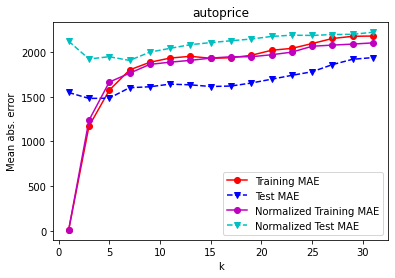

In [22]:
##################################################
# Hold-out testing: Variation on k parameter
##################################################
def hold_out_regression_value_k_range(xtr, xt, ytr, yt, k_r, title):
    tr_acc = np.zeros(len(k_r))
    t_acc = np.zeros(len(k_r))
    tr_acc_n = np.zeros(len(k_r))
    t_acc_n = np.zeros(len(k_r))
    n_xtr = normalize(xtr)
    n_xt = normalize(xt)
    i = 0
    for k in k_r:
        clf = kNN(k)
        clf.fit(xtr, ytr)
        tr_acc[i] = mean_absolute_error(ytr.values, clf.get_prediction(xtr)['regression value'])
        t_acc[i] = mean_absolute_error(yt.values, clf.get_prediction(xt)['regression value'])
        clf.fit(n_xtr, ytr)
        tr_acc_n[i] = mean_absolute_error(ytr.values, clf.get_prediction(n_xtr)['regression value'])
        t_acc_n[i] = mean_absolute_error(yt.values, clf.get_prediction(n_xt)['regression value'])
        i += 1

    plt.plot(k_r, tr_acc, 'ro-',
             k_r, t_acc, 'bv--',
             k_r, tr_acc_n, 'mo-',
             k_r, t_acc_n, 'cv--')
    plt.legend(['Training MAE', 'Test MAE',
                'Normalized Training MAE', 'Normalized Test MAE'])
    plt.xlabel('k')
    plt.ylabel('Mean abs. error')
    plt.title(title)
    plt.show()
    return

X_Train, X_Test, Y_Train, Y_Test = read_data('data/autoprice.csv')
hold_out_regression_value_k_range(X_Train, X_Test, Y_Train, Y_Test, k_range, 'autoprice')

